In [1]:
import pandas as pd 
import arviz 
import pickle

import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

# matplotlib.use('Agg')  # noqa: E402

In [2]:
bd = pd.read_csv('./numpyro/birthdays.txt')

lam_date_join = lambda row: f"{row['year']}-{row['month']}-{row['day']}"
bd["date"] = pd.to_datetime(bd.apply(lam_date_join, axis=1), format="%Y-%m-%d")

lam_get_day = lambda date: date.days

bd_sm = bd[bd["year"] <= 1970]
bd_sm['date_indexed'] = (bd_sm['date'] - bd_sm['date'].min()).apply(lam_get_day)
# bd_sm['date_normed'] = (bd_sm['date_indexed'] - bd_sm['date_indexed'].mean()) / bd_sm['date_indexed'].std()
bd_sm['births_normed'] = (bd_sm['births'] - bd_sm['births'].mean()) / bd_sm['births'].std()

# date_scale = 1/bd_sm['date_indexed'].std() # one day corresps to date_scale normed days

bd_sm['date_normed'] = bd_sm['date_indexed']
# bd_sm['births_normed'] = bd_sm['births']


# add in the special days

# get the day of the week (used for some holidays)
n_weeks = int(np.ceil(bd_sm.shape[0] / 7))
bd_sm["weekdays"] = pd.Series(["Wed","Thr","Fri","Sat","Sun","Mon","Tue"] * n_weeks)

def find_holiday(df: pd.DataFrame, month: int, weekday: str, n: int):
    """
        Get indicator column for holiday which occurs on
        n-th weekday of month. (n=-1 for last)
    """
    indic = pd.Series(0, df.index) 
    hols = df.query(f"month == {month} and weekdays == '{weekday}'").groupby(by=['year']).nth(n=n)
    for j in range(hols.shape[0]): # for each one...
        j_date = hols.iloc[j]["date"] # ...get the date...
        indic[df["date"]==j_date] = 1 # ...and record it

    return indic

bd_sm["spd_newyears"] = ((bd_sm["month"] == 1) & (bd_sm["day"] == 1)).astype(int)
bd_sm["spd_val"] = ((bd_sm["month"] == 2) & (bd_sm["day"] == 14)).astype(int)
bd_sm["spd_leap"] = ((bd_sm["month"] == 2) & (bd_sm["day"] == 29)).astype(int)
bd_sm["spd_aprilf"] = ((bd_sm["month"] == 4) & (bd_sm["day"] == 1)).astype(int)
bd_sm["spd_memorial"] = find_holiday(bd_sm, month=5, weekday='Mon', n=-1) 
bd_sm["spd_indep"] = ((bd_sm["month"] == 7) & (bd_sm["day"] == 4)).astype(int)
bd_sm["spd_labor"] = find_holiday(bd_sm, month=9, weekday='Mon', n=0) 
bd_sm["spd_halloween"] = ((bd_sm["month"] == 10) & (bd_sm["day"] == 31)).astype(int)
bd_sm["spd_thanks"] = find_holiday(bd_sm, month=11, weekday='Thr', n=3)
bd_sm["spd_xmas"] = ((bd_sm["month"] == 12) & (bd_sm["day"] == 25)).astype(int)

In [3]:
# X = bd_sm[['date_normed', 'spd_newyears', 'spd_val', 'spd_leap', 'spd_aprilf',
#     'spd_memorial','spd_indep','spd_labor','spd_halloween','spd_thanks',
#     'spd_xmas']].values[:,:]
# y = bd_sm['births_normed'].values[:,None]

In [4]:
X = bd_sm[["date_indexed"]].values[:]
Y = bd_sm[["births_normed"]].values[:]

n = X.shape[0]
n_train = int(np.floor(.8*n))
# tts_idx = np.random.permutation(range(n))
tts_idx = range(n) # no shuffling

X_test = X[tts_idx[n_train:]]
Y_test = Y[tts_idx[n_train:]]
X = X[tts_idx[:n_train]]
Y = Y[tts_idx[:n_train]]

## Kernels

In [12]:
def kernel_sqexp(X,Xp,sigma,length,noise, jitter=1.0e-6, include_noise=True):
    """Radial basis function/Gaussian kernel.
    
    Args:
        X,Xp (np.ndarray): two dataset inputs to kernel.
        sigma (float): standard deviation parameter.
        length (float): length scale parameter.

    """
    k = sigma * jnp.exp(-0.5 * jnp.power((X-Xp)/length, 2.))
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k

In [15]:
def model(X, Y):
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute the (observed data) kernel
    k = kernel_sqexp(X, X, var, length, noise)

    # sample Y according to standard GP formula
    numpyro.sample("Y", dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
        obs=Y)

In [14]:
from numpyro.infer import MCMC, NUTS, init_to_value, init_to_median, init_to_feasible, init_to_sample, init_to_uniform

class Args:
    num_chains = 1
    num_samples = 1_000
    num_warmup = 1_000
    num_data = 25
    device = 'cpu' #'gpu'
    init_strategy = 'value'

args = Args()

numpyro.set_platform(args.device)
numpyro.set_host_device_count(args.num_chains)


# do the inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))


start = time.time()

# different HMC initialization strategies
if args.init_strategy == "value":
    init_strategy = init_to_value(values={"kernel_var":1., "kernel_noise":.05, "kernel_length":.5})
elif args.init_strategy == "median":
    init_strategy = init_to_median(num_samples=10)
elif args.init_strategy == "feasible":
    init_strategy = init_to_feasible()
elif args.init_strategy == "sample":
    init_strategy = init_to_sample()
elif args.init_strategy == "uniform":
    init_strategy = init_to_uniform(radius=1)

kernel = NUTS(model, init_strategy=init_strategy)
mcmc = MCMC(kernel, args.num_warmup, args.num_samples, num_chains=args.num_chains,
    progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
mcmc.run(rng_key, X, Y)
mcmc.print_summary()

samples = mcmc.get_samples()

print('\nMCMC elapsed time: ', time.time()-start)

# do prediction
vmap_args = (random.split(rng_key_predict, args.num_samples * args.num_chains), samples['kernel_var'],
    samples['kernel_length'], samples['kernel_noise'])
means, predictions = vmap(lambda rng_key, var, length, noise:
    predict(rng_key, X, Y, X_test, var, length, noise))(*vmap_args)

mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5., 95.], axis=0)




NameError: name 'noise' is not defined

# Define kernels

In [22]:
def kernel(X,Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:,None]-Z)/length, 2.)
    k = var * jnp.exp(-.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k

# Define the model

In [23]:
def model(X, Y):
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute the kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to standard GP formula
    numpyro.sample("Y", dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
        obs=Y)

# Wrapper function for performing inference

In [32]:
from numpyro.infer import MCMC, NUTS, init_to_value, init_to_median, init_to_feasible, init_to_sample, init_to_uniform

def run_inference(model, args, rng_key, X, Y):
    start = time.time()

    # different HMC initialization strategies
    if args.init_strategy == "value":
        init_strategy = init_to_value(values={"kernel_var":1., "kernel_noise":.05, "kernel_length":.5})
    elif args.init_strategy == "median":
        init_strategy = init_to_median(num_samples=10)
    elif args.init_strategy == "feasible":
        init_strategy = init_to_feasible()
    elif args.init_strategy == "sample":
        init_strategy = init_to_sample()
    elif args.init_strategy == "uniform":
        init_strategy = init_to_uniform(radius=1)

    kernel = NUTS(model, init_strategy=init_strategy)
    mcmc = MCMC(kernel, args.num_warmup, args.num_samples, num_chains=args.num_chains,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
    mcmc.run(rng_key, X, Y)
    mcmc.print_summary()

    print('\nMCMC elapsed time: ', time.time()-start)
    return mcmc.get_samples()

# Do prediction, given a set of hyperparameters

In [25]:
def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute the kernels (blocks)
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)

    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))

    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.)) * jax.random.normal(rng_key, X_test.shape[:1])
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))

    return mean, mean+sigma_noise # return mean and a sample from posterior predictive

# Make data

In [26]:
def get_data(N=30, sigma_obs=0.15, N_test=400):
    np.random.seed(0)
    X = jnp.linspace(-1,1,N)
    Y = X + 0.2 * jnp.power(X, 3.) + 0.5 * jnp.power(0.5 + X, 2.) * jnp.sin(4. * X)
    Y += sigma_obs * np.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)

    assert X.shape == (N,)
    assert Y.shape == (N,)

    X_test = jnp.linspace(-1.3, 1.3, N_test)

    return X, Y, X_test

# Run it

In [33]:
class Args:
    num_chains = 1
    num_samples = 1_000
    num_warmup = 1_000
    num_data = 25
    device = 'cpu' #'gpu'
    init_strategy = 'value'

args = Args()

numpyro.set_platform(args.device)
numpyro.set_host_device_count(args.num_chains)



X, Y, X_test = get_data(N=args.num_data)

# do the inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(model, args, rng_key, X, Y) # wrapper fn

# do prediction
vmap_args = (random.split(rng_key_predict, args.num_samples * args.num_chains), samples['kernel_var'],
    samples['kernel_length'], samples['kernel_noise'])
means, predictions = vmap(lambda rng_key, var, length, noise:
    predict(rng_key, X, Y, X_test, var, length, noise))(*vmap_args)

mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5., 95.], axis=0)


sample: 100%|██████████| 2000/2000 [00:12<00:00, 159.93it/s, 7 steps of size 4.91e-01. acc. prob=0.94] 

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.71      0.22      0.67      0.36      1.02    507.98      1.00
   kernel_noise      0.06      0.02      0.06      0.03      0.09    574.15      1.00
     kernel_var      2.85      5.61      1.45      0.22      5.44    530.29      1.00

Number of divergences: 0

MCMC elapsed time:  15.481137990951538


# visualize output

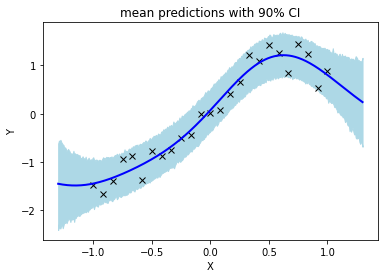

<Figure size 432x288 with 0 Axes>

In [40]:
fig, ax = plt.subplots(1,1)

ax.plot(X,Y, 'kx')

ax.fill_between(X_test, percentiles[0,:], percentiles[1,:], color='lightblue',)

ax.plot(X_test, mean_prediction, 'blue', ls='solid', lw=2.)
ax.set(xlabel='X',ylabel='Y', title="mean predictions with 90% CI")

plt.show()
plt.tight_layout()